In [3]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

In [4]:
def iewt1d(ewt, mfb):
    # 转化为原始信号
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

In [5]:
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def metircs(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    mape = MAPE(pred, true)
    return {"rmse":rmse, "r2":r2, "mape":mape}

## 数据加载

In [6]:
TARGET = "5f5533cpu"
cols = [TARGET]
N = 3

df = pd.read_csv(f"./data/{TARGET}.csv", index_col=[0], parse_dates=True)
df.head()
metrics_dict = {}

,5f5533cpu,5f5533cpu0,5f5533cpu1,5f5533cpu2,5f5533cpu0_mfb,5f5533cpu1_mfb,5f5533cpu2_mfb
timestamp,,,,,,,
2014-02-14 14:27:00,51.846,42.652951,2.215748,-0.885677,1.000000,0.000000,0.0
2014-02-14 14:32:00,44.508,42.667718,2.260513,-0.885677,1.000000,0.000000,0.0
2014-02-14 14:37:00,41.244,42.682476,2.305279,-5.179304,1.000000,0.000034,0.0
2014-02-14 14:42:00,48.568,42.697224,2.350044,2.899107,0.956631,0.291302,0.0
2014-02-14 14:47:00,46.714,42.711962,2.394810,0.491100,0.291302,0.956631,0.0


## lstm-ewt 预测

In [7]:
seq_len, pred_len = 80, 1
total_len = len(df)
model_name = "lstmewt"

In [8]:
# 不同horizon下的分量预测结果
lstmewt_horizon_dict = {}
for hn in range(1, 21):
    # 加载不同horizon下的各分量预测结果
    pred_lst = []
    # true_lst = []
    for i in range(N):
        true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}{i}_0/true_pred.pkl")
        # true_lst.append(true)
        pred_lst.append(pred)
    pred_lstm = np.concatenate(pred_lst,axis=-1)
    # true_lstm = np.concatenate(true_lst, axis=-1)
    lstmewt_horizon_dict[hn] = pred_lstm

In [9]:
target_horizon = 1
lstmewt_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values
        # seq_len部分的ewt
        pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
        # 和预测得到的ewt组合
        pred_horizon = lstmewt_horizon_dict[horizon][:,0,:]
        # pred_horizon = pred_lstm[:,target_horizon-1,:]]
        ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
        # 重构
        reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = reconstruction[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test)
        
        lstmewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstmewt_target_horizon_data = [target, reconstruction, ewt_pred]
trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
lstmewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstmewt"] = pd.DataFrame(lstmewt_metrics).T

In [10]:
metrics_dict["lstmewt"]

,rmse,r2,mape
horizon1,4.012516,-15.793150,0.101658
horizon2,4.039044,-16.015934,0.101863
horizon3,4.016673,-15.827968,0.100860
horizon4,3.965223,-15.381353,0.099782
horizon5,3.926267,-15.061057,0.098306
horizon6,3.997469,-15.648867,0.100967
horizon7,3.948672,-15.244886,0.099809
horizon8,4.043406,-16.033710,0.101595
horizon9,4.144693,-16.878219,0.104832
horizon10,3.980769,-15.492003,0.100426


### target_horizon展示

In [11]:
target, reconstruction, ewt_pred = lstmewt_target_horizon_data
gap = target_horizon - 1

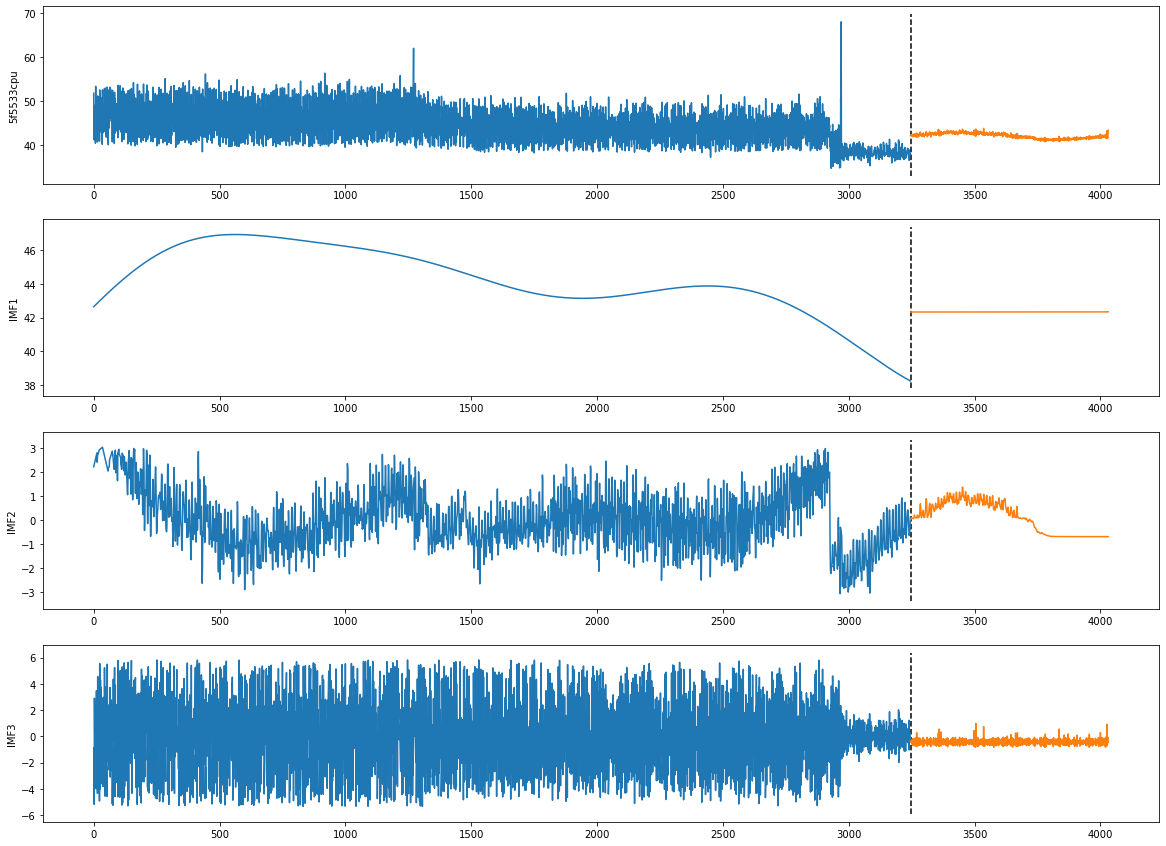

In [12]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

In [13]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

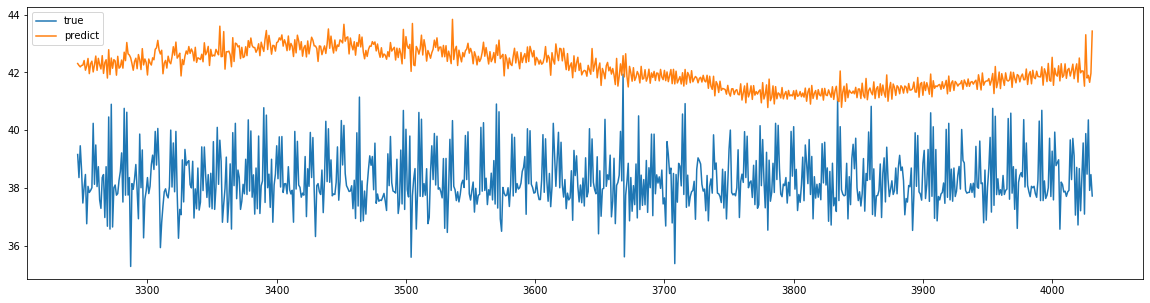

In [14]:
fig = plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:], label="predict")
plt.legend();

In [15]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

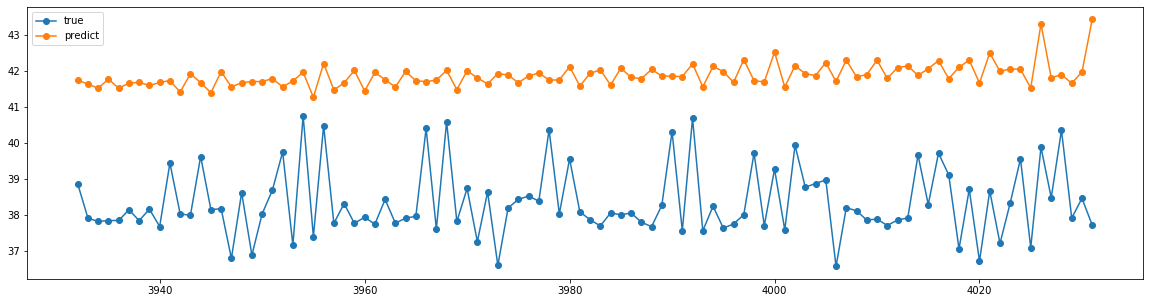

In [16]:
fig = plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-select_length, len(df)), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-select_length, len(df)), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

In [17]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## lstm 预测

In [18]:
seq_len, pred_len = 80, 1
total_len = len(df)

In [19]:
lstm_horizon_dict = {}
for hn in range(1, 21):
    true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}_0/true_pred.pkl")
    lstm_horizon_dict[hn] = pred

In [20]:
target_horizon = 1
lstm_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        # seq_len部分的col
        pre_col = df.iloc[:pre_len][[col]]
        # 和预测得到的col组合
        pred_horizon = lstm_horizon_dict[horizon][:,0,:]
        pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = pred_horizon[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test.flatten())
        
        lstm_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstm_target_horizon_data = [target, pred_horizon]
    
trues_test_all, preds_test_all = np.concatenate(trues_test_lst), np.concatenate(preds_test_lst)
lstm_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstm"] = pd.DataFrame(lstm_metrics).T

In [21]:
metrics_dict["lstm"]

,rmse,r2,mape
horizon1,5.380827,-29.199293,0.138981
horizon2,4.289724,-18.193637,0.109986
horizon3,5.438635,-29.851657,0.140516
horizon4,5.443636,-29.873982,0.140645
horizon5,5.328053,-28.576826,0.137572
horizon6,5.352280,-28.846409,0.138217
horizon7,5.352768,-28.851851,0.138230
horizon8,5.293890,-28.198755,0.136664
horizon9,5.402939,-29.380832,0.139560
horizon10,4.823292,-23.211776,0.124269


## former-ewt 预测

In [22]:
seq_len, label_len, pred_len = 80, 10, 20
total_len = len(df)
target_horizon_data_dict = {}
target_horizon = 1

In [23]:
for model_name in ["auto", "in", "trans"]:
    # 读取数据
    ewt_pred_lst = []
    for i in range(N):
        true_, pred_ = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs32_lr0.0001_{TARGET}{i}_0/true_pred.pkl")
        ewt_pred_lst.append(pred_)
    model_ewt_pred = np.concatenate(ewt_pred_lst,axis=-1)    
    
    ewt_metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, 21):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            # former多步预测时，截断了最后horizon个步长，为了对齐，要截断
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values[:-align_len]
            # seq_len部分的ewt
            pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
            # 和预测得到的ewt组合
            pred_horizon = model_ewt_pred[:,horizon-1,:]
            ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
            # 重构
            reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = reconstruction[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test)

            ewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
        if horizon == target_horizon:
            ewt_target_horizon_data = [target, reconstruction, ewt_pred]
            target_horizon_data_dict[model_name+"ewt"] = ewt_target_horizon_data
            
    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    ewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}ewt"] = pd.DataFrame(ewt_metrics).T

In [24]:
metrics_dict[f"{model_name}ewt"]

,rmse,r2,mape
horizon1,4.620571,-21.534043,0.117673
horizon2,4.234116,-17.923559,0.107414
horizon3,4.503422,-20.383339,0.113869
horizon4,4.297611,-18.485821,0.108799
horizon5,4.346160,-18.873073,0.110457
horizon6,4.236941,-17.869112,0.106407
horizon7,4.271181,-18.139303,0.107771
horizon8,4.288767,-18.292455,0.108662
horizon9,4.095151,-16.557950,0.103754
horizon10,4.177185,-17.264840,0.105134


### target_horizon展示

In [25]:
show_model = "auto"
target, reconstruction, ewt_pred = target_horizon_data_dict[show_model+"ewt"]
gap = target_horizon-1

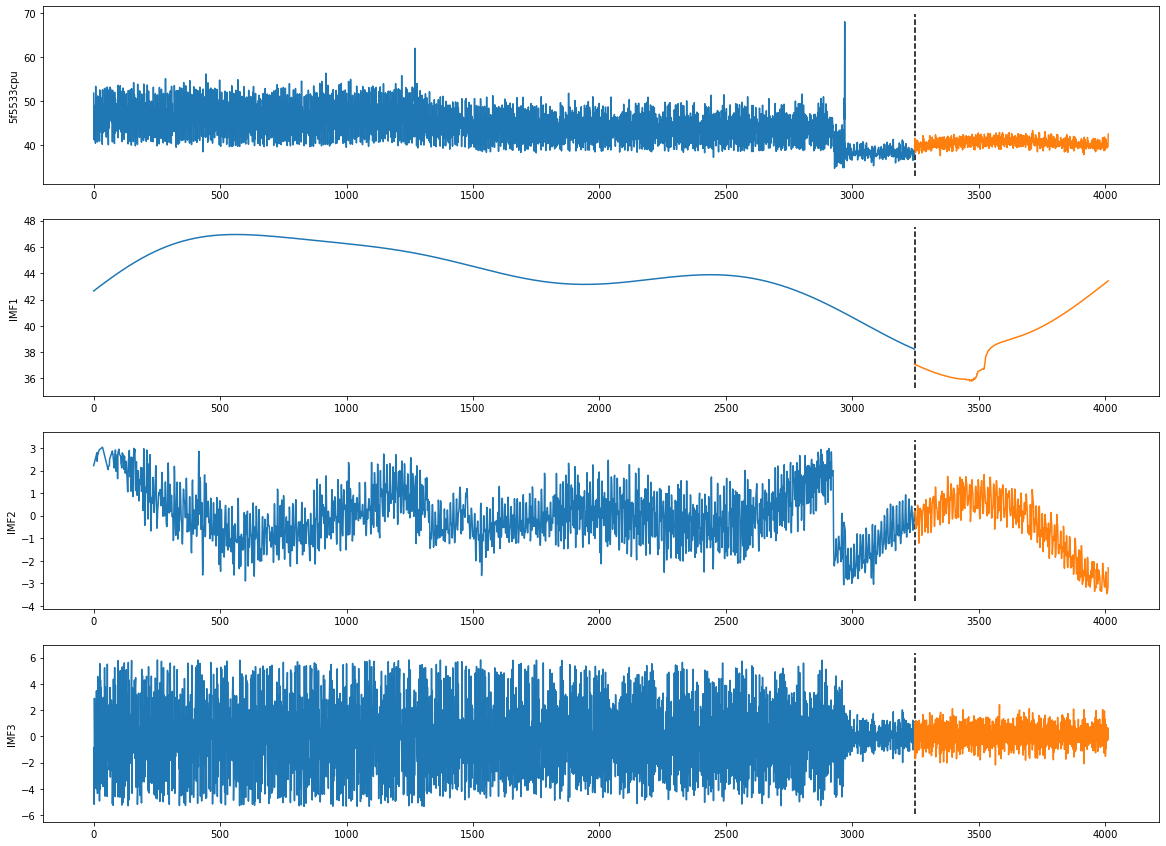

In [26]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

In [27]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

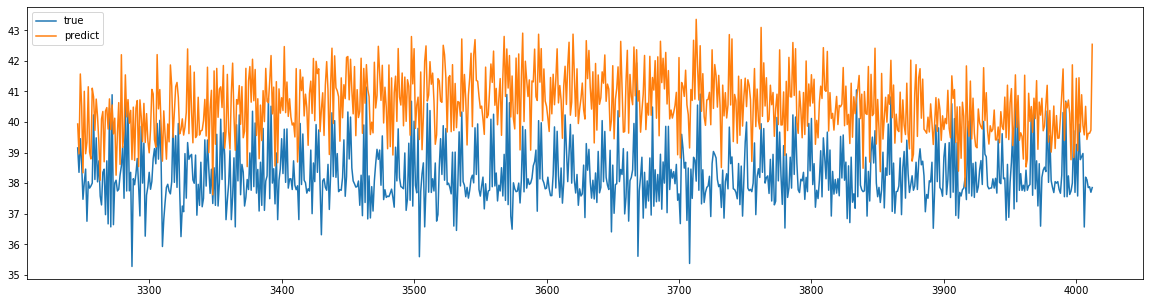

In [28]:
fig = plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:], label="predict")
plt.legend();

In [29]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

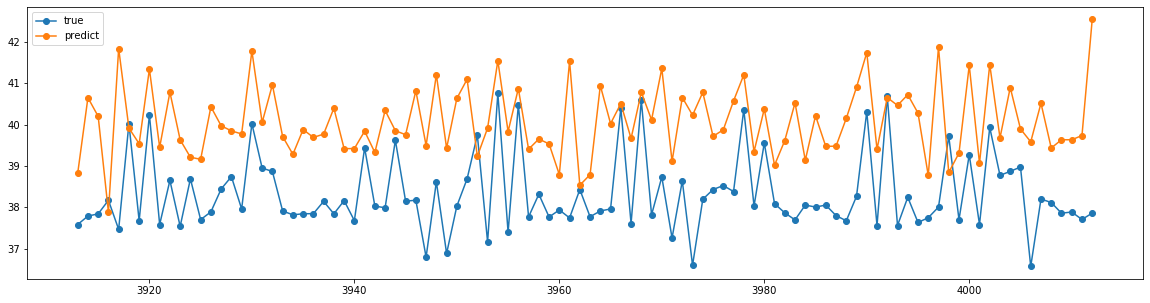

In [30]:
fig = plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

In [31]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## former预测

In [32]:
seq_len, label_len, pred_len = 80, 10, 20
total_len = len(df)
target_horizon = 1

In [33]:
for model_name in ["auto", "in", "trans"]:
    _true, _pred = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs32_lr0.0001_{TARGET}_0/true_pred.pkl")

    _metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, 21):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            # seq_len部分的col
            pre_col = df.iloc[:pre_len][[col]]
            # 和预测得到的col组合
            pred_horizon = _pred[:,horizon-1,:]
            pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = pred_horizon[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test.flatten())

            _metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
        if horizon == target_horizon:
            _target_horizon_data = [target, pred_horizon]

    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    _metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}"] = pd.DataFrame(_metrics).T

In [34]:
metrics_dict[f"{model_name}"]

,rmse,r2,mape
horizon1,5.720506,-33.539549,0.147587
horizon2,4.078363,-16.556942,0.103993
horizon3,4.414012,-19.542681,0.111826
horizon4,4.422195,-19.631947,0.113388
horizon5,4.441313,-19.752780,0.114007
horizon6,2.926238,-8.000485,0.073395
horizon7,4.054907,-16.250111,0.103291
horizon8,4.082809,-16.483996,0.104339
horizon9,5.158098,-26.855646,0.133166
horizon10,4.986502,-25.027987,0.128478


## arima rolling

In [35]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARIMA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [36]:
def get_result(val_data, test_data, rolling=True, pred_len=20, seq_len=200):
    history = [x for x in val_data[-seq_len:, 0]]

    preds_lst = list()
    trues_lst = list()
    initial = True
    for t in tqdm(range(len(test_data[:, 0])-pred_len)):
        history = history[-seq_len:]
        if initial:
            model = ARMA(history, order=(5, 0, 0))
            try:
                model_fit = model.fit()
            except:
                model_fit = model.fit(start_params=model_fit.params)
                
            # 仅估计一次模型，否则，滚动预测，迭代feed数据，重新估计模型
            if not rolling:
                initial = False
            
        output = model_fit.forecast(pred_len)
        yhat = output[0]
        preds_lst.append(yhat)
        obs = test_data[:, 0][t]
        history.append(obs)
        trues_lst.append(test_data[:, 0][t:t+pred_len])
    return preds_lst, trues_lst

In [37]:
val_size = int(len(df)*0.1)
test_size = int(len(df)*0.2)
ar_data = df[cols].values
train_data, val_data, test_data \
    = ar_data[:(len(df)-test_size-val_size)], ar_data[(len(df)-test_size-val_size):(len(df)-test_size)], ar_data[-test_size:]

In [38]:
# arma_model=ARMA(train_data[:, 0], order=(5, 0, 0))
# arma_result=arma_model.fit()
# arma_result.summary()

In [52]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=True)

  0%|          | 0/786 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [53]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_rolling"] = pd.DataFrame(ar_metrics).T

In [54]:
metrics_dict["arima_rolling"]

,rmse,r2,mape
horizon1,0.876658,0.190159,0.017722
horizon2,0.896187,0.152294,0.017978
horizon3,0.938392,0.070508,0.018881
horizon4,0.962048,0.024148,0.019234
horizon5,0.962427,0.022762,0.019224
horizon6,0.975728,-0.001638,0.019560
horizon7,0.973776,0.003299,0.019509
horizon8,0.974650,0.003384,0.019516
horizon9,0.963590,0.026117,0.019328
horizon10,0.963504,0.028057,0.019338


## arima static

In [41]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=False)

  0%|          | 0/786 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [42]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_static"] = pd.DataFrame(ar_metrics).T

In [43]:
metrics_dict["arima_static"]

,rmse,r2,mape
horizon1,0.980899,-0.013883,0.020368
horizon2,0.973375,-0.000018,0.019528
horizon3,0.994823,-0.044646,0.018732
horizon4,1.021462,-0.100106,0.018888
horizon5,0.998640,-0.052162,0.018744
horizon6,0.975267,-0.000692,0.019409
horizon7,0.976364,-0.002005,0.019891
horizon8,0.990930,-0.030188,0.020932
horizon9,0.990414,-0.028860,0.020906
horizon10,0.988070,-0.022138,0.020733


## 模型评估

In [44]:
def evaluation_show(taget_indictor, target_horizon, sort=True):
    hist_dict = {}
    for key, value in metrics_dict.items():
        hist_dict[key] = value[taget_indictor][target_horizon]
    if sort:
        hist_dict = dict(sorted(hist_dict.items(), key=lambda x:x[1]))
    fig = plt.figure(figsize=(10, 6))
    x, width = 0, 0.25
    xtick_lst = []
    xlabel_lst = []
    for key, value in hist_dict.items():
        xtick_lst.append(x)
        xlabel_lst.append(key)
        plt.bar(x, value, width=width, label=key)
        x += width
    plt.xticks(xtick_lst, xlabel_lst)
    plt.title(f"{taget_indictor}_{target_horizon}")
    plt.legend();
    return fig, hist_dict

In [55]:
target_horizon = "allhorizon"

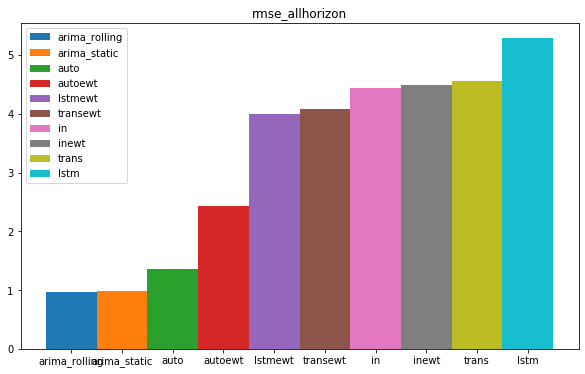

In [56]:
taget_indictor = 'rmse'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

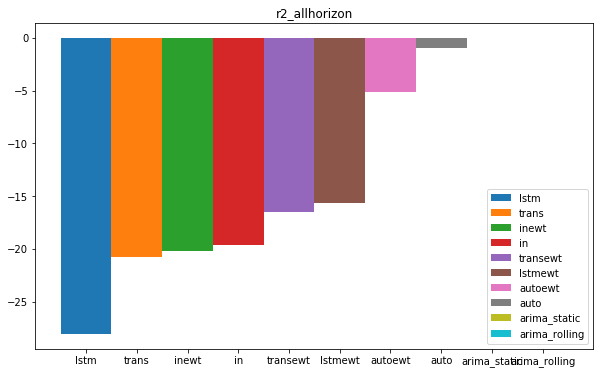

In [57]:
taget_indictor = 'r2'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

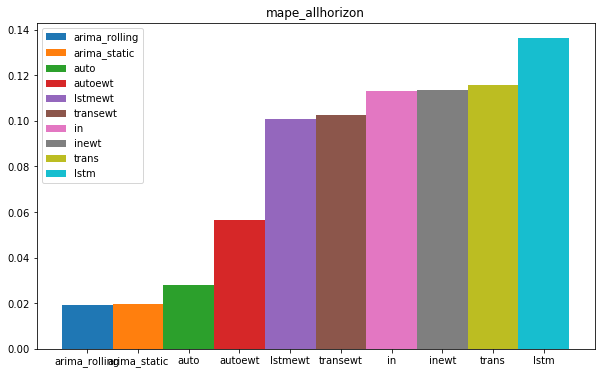

In [58]:
taget_indictor = 'mape'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

### save_metrics

In [72]:
save_metrics = {}
for key, value in metrics_dict.items():
    save_metrics[key] = metrics_dict[key].loc[target_horizon, :].to_dict()

In [76]:
pd.DataFrame(save_metrics).T

,rmse,r2,mape
lstmewt,3.998587,-15.642492,0.100987
lstm,5.284120,-28.063679,0.136237
autoewt,2.425945,-5.161358,0.056339
inewt,4.497306,-20.174808,0.113447
transewt,4.085379,-16.473475,0.102741
auto,1.354137,-0.919729,0.028128
in,4.438274,-19.622570,0.113222
trans,4.559996,-20.769253,0.115881
arima_static,0.984652,-0.015778,0.019881
arima_rolling,0.964158,0.026066,0.019343
